Import libraries and dataset `atlantic.csv`

In [116]:
!pip install wandb -q

In [117]:
!wandb login 03697d38e9eca7bd6d9b6de1fc24cb8cd504fd51

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import pmdarima as pm

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

from typing import Union, Tuple

import wandb
from wandb.keras import WandbCallback

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Path to the dataset file if I use Google Colab
# DATASET_PATH = "/content/drive/MyDrive/ML_academy/task_3/atlantic.csv"

# Alternatively, you can use a relative path if you run code in local machine
DATASET_PATH = "data/atlantic.csv"

## Подготовка данных

Чтение набора данных в объект DataFrame с помощью Pandas

In [3]:
df = pd.read_csv(DATASET_PATH)
df.head()

,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,...,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW
0,AL011851,UNNAMED,18510625,0,,HU,28.0N,94.8W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
1,AL011851,UNNAMED,18510625,600,,HU,28.0N,95.4W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
2,AL011851,UNNAMED,18510625,1200,,HU,28.0N,96.0W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
3,AL011851,UNNAMED,18510625,1800,,HU,28.1N,96.5W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
4,AL011851,UNNAMED,18510625,2100,L,HU,28.2N,96.8W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999


В признаке `Name` есть проблема лишних пробелов. Выполнил их удаление

In [4]:
df["Name"].value_counts().index

Index(['            UNNAMED', '            FRANCES', '             ARLENE',
       '             BERTHA', '             DENNIS', '           FLORENCE',
       '             HELENE', '              IRENE', '              EMILY',
       '             BONNIE',
       ...
       '              EIGHT', '              PATTY', '               ALFA',
       '             EVELYN', '           NINETEEN', '              SHARY',
       '              TAMMY', '            SIXTEEN', '            FERNAND',
       '             AMELIA'],
      dtype='object', name='Name', length=288)

In [5]:
df['Name'] = df['Name'].str.strip()

Преобразование столбца "Date" в формат datetime

In [6]:
df["Date"] = pd.to_datetime(df["Date"] , format= "%Y%m%d")

Аналогичное действие сделал со временем

In [7]:
def convert_to_time(time_value: int) -> pd.Timedelta:
    """
    Function to convert time from integer format to Timedelta format.

    Parameters:
    - time_value: int, integer representation of time in HHMM format.

    Returns:
    - pd.Timedelta: Timedelta object representing time in hours and minutes.
    """
    # Extracting hours and minutes from the integer time value
    hours = time_value // 100
    minutes = time_value % 100

    # Creating a Timedelta object with specified hours and minutes
    return pd.Timedelta(hours=hours, minutes=minutes)

In [8]:
df["Time"] = df["Time"].apply(convert_to_time)

Создал столбец `Datetime`

In [9]:
df['Datetime'] = df['Date'] + df['Time']
df['Datetime'] = pd.to_datetime(df['Datetime'])

Удалим столбец `Time` за ненадобностью

In [10]:
df.drop(["Time"], axis=1, inplace=True)

Преобразование географических координат в удобный формат

In [13]:
def convert_coordinates(coordinate: str) -> Union[float, None]:
    """
    Function to convert coordinates from string format to float format.

    Parameters:
    - coordinate: str, string representation of coordinates in format 'XX.XXXX{N/S/E/W}'.

    Returns:
    - float: Converted coordinate value.
    - None: If coordinate format is invalid.
    """
    if coordinate[-1] in ('E', 'N') :
        return float(coordinate[:-1])
    elif coordinate[-1] in ('W', 'S'):
        return -float(coordinate[:-1])
    else:
        return None

In [14]:
df['Latitude_numeric'] = df['Latitude'].apply(convert_coordinates)
df['Longitude_numeric'] = df['Longitude'].apply(convert_coordinates)

Заменим отрицательные значения для столбца `Maximum Wind` на медианное значение, т.к. они не соответствуют реальности

In [15]:
df["Maximum Wind"].replace([-99.0], df["Maximum Wind"].median(), inplace=True)

/var/folders/q4/4l6ccgc547zfl_j4t8vqnm9c0000gn/T/ipykernel_47014/4251838519.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Maximum Wind"].replace([-99.0], df["Maximum Wind"].median(), inplace=True)


Установка столбца `Datetime` в качестве индекса DataFrame

In [16]:
df.set_index("Datetime", inplace=True)

In [17]:
df.head()

,ID,Name,Date,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,Low Wind NE,...,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW,Latitude_numeric,Longitude_numeric
Datetime,,,,,,,,,,,,,,,,,,,,,
1851-06-25 00:00:00,AL011851,UNNAMED,1851-06-25,,HU,28.0N,94.8W,80,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,28.0,-94.8
1851-06-25 06:00:00,AL011851,UNNAMED,1851-06-25,,HU,28.0N,95.4W,80,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,28.0,-95.4
1851-06-25 12:00:00,AL011851,UNNAMED,1851-06-25,,HU,28.0N,96.0W,80,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,28.0,-96.0
1851-06-25 18:00:00,AL011851,UNNAMED,1851-06-25,,HU,28.1N,96.5W,80,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,28.1,-96.5
1851-06-25 21:00:00,AL011851,UNNAMED,1851-06-25,L,HU,28.2N,96.8W,80,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,28.2,-96.8


Проверим датафрейм на пропуски значений

In [18]:
df.isna().sum()

ID                   0
Name                 0
Date                 0
Event                0
Status               0
Latitude             0
Longitude            0
Maximum Wind         0
Minimum Pressure     0
Low Wind NE          0
Low Wind SE          0
Low Wind SW          0
Low Wind NW          0
Moderate Wind NE     0
Moderate Wind SE     0
Moderate Wind SW     0
Moderate Wind NW     0
High Wind NE         0
High Wind SE         0
High Wind SW         0
High Wind NW         0
Latitude_numeric     0
Longitude_numeric    0
dtype: int64

## EDA

Вывод описательных статистик для DataFrame

In [19]:
df.describe()

,Date,Maximum Wind,Minimum Pressure,Low Wind NE,Low Wind SE,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW,Latitude_numeric,Longitude_numeric
count,49105,49105.000000,49105.000000,49105.000000,49105.000000,49105.000000,49105.000000,49105.000000,49105.000000,49105.000000,49105.000000,49105.000000,49105.000000,49105.000000,49105.000000,49105.000000,49105.000000
mean,1950-05-26 04:02:32.782812288,52.996273,-251.406496,-868.671031,-869.315772,-872.676428,-871.409245,-875.570940,-875.765319,-876.682028,-876.323205,-877.564321,-877.655045,-877.923552,-877.786295,27.044904,-65.682533
min,1851-06-25 00:00:00,10.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,7.200000,-359.100000
25%,1911-11-01 00:00:00,35.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,19.100000,-81.000000
50%,1956-09-27 00:00:00,45.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,26.400000,-68.000000
75%,1989-08-10 00:00:00,70.000000,990.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,33.100000,-52.500000
max,2015-11-13 00:00:00,165.000000,1024.000000,710.000000,600.000000,640.000000,530.000000,360.000000,300.000000,330.000000,360.000000,180.000000,250.000000,150.000000,180.000000,81.000000,63.000000
std,NaN,24.671546,964.313907,353.299666,351.548910,342.153768,345.628984,333.651396,333.133376,330.526085,331.535176,328.027275,327.774794,327.021430,327.408253,10.077880,19.687240


Для таких показателей, как минимальное давление, скорость ветра (исключая максимальную скорость), наблюдаются проблемы. Их средние значения отрицательные, что может быть связано с отсутствием данных (-999.000)

Посмотрим на общую картину наблюдений ураганов

Статистика за каждый год

In [18]:
# Creating a new column 'Year' containing the observation year
df['Year'] = df.index.year

# Grouping the data by year and counting the number of hurricanes for each year
hurricanes_per_year = df.groupby('Year').size()

# Converting the index of the Series to datetime format with year using to_period and to_timestamp
hurricanes_per_year.index = pd.to_datetime(hurricanes_per_year.index, format='%Y').to_period('Y').to_timestamp('Y')

In [19]:
hurricanes_per_year

Year
1851-12-31     98
1852-12-31    134
1853-12-31    100
1854-12-31     60
1855-12-31     35
             ... 
2011-12-31    557
2012-12-31    654
2013-12-31    346
2014-12-31    300
2015-12-31    339
Freq: YE-DEC, Length: 165, dtype: int64

In [20]:
hurricanes_per_year.to_csv("data/hurricanes_per_year.csv")

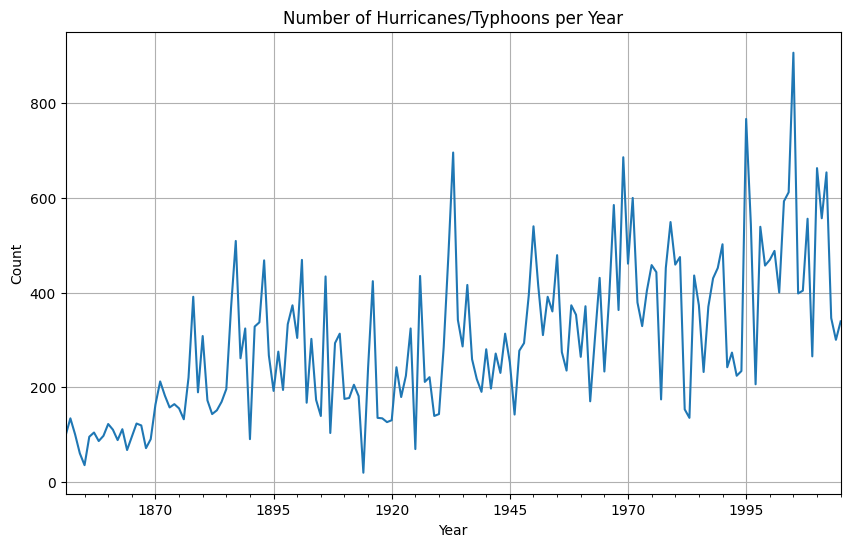

In [25]:
hurricanes_per_year.plot(kind='line', figsize=(10, 6))

plt.title('Number of Hurricanes/Typhoons per Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.grid(True)

plt.show()

Статистика за каждый месяц

In [28]:
import calendar

In [29]:
# Getting month names
month_names = [calendar.month_abbr[i] for i in range(1, 13)]  # Using month_abbr to get abbreviated month names

In [26]:
# Creating a new column 'Month' containing the observation month
df['Month'] = df.index.month

# Grouping the data by year and counting the number of hurricanes for each month
hurricanes_per_month = df.groupby('Month').size()

# Converting the index of the Series to datetime format with month using to_period and to_timestamp
hurricanes_per_month.index = pd.to_datetime(hurricanes_per_month.index, format='%M').to_period('M').to_timestamp('M')

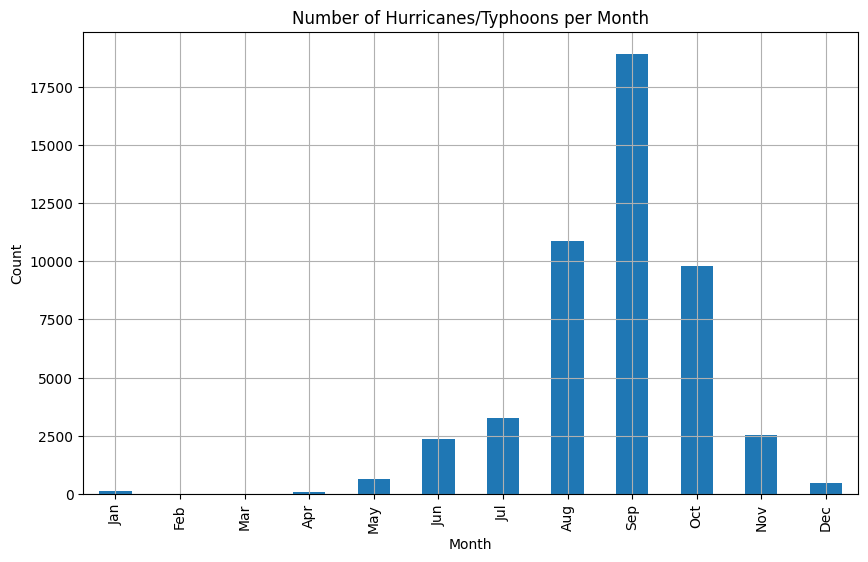

In [30]:
hurricanes_per_month.plot(kind='bar', figsize=(10, 6))

plt.title('Number of Hurricanes/Typhoons per Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(range(12), month_names)  # Setting ticks from 0 to 11 with corresponding month names

plt.grid(True)

plt.show()

График позволяет легко увидеть, что большинство штормов происходят с середины лета до конца осени, с пиком в сентябре. Это соответствует периоду пика сезона тропических циклонов в северном полушарии (в данном примере на Атлантическом побережье Америки), когда условия окружающей среды, наиболее благоприятны для формирования и интенсификации штормов

Проверка временного ряда на стационарность

In [31]:
from statsmodels.tsa.stattools import adfuller

In [32]:
# Performing the Dickey-Fuller test
result = adfuller(hurricanes_per_year, autolag='AIC')

# Printing the test results
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print(f'Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value:.3f}')

# Checking for stationarity based on the test results
if result[0] > result[4]['5%']:
    print('Имеются единичные корни, ряд не стационарен')
else:
    print('Единичных корней нет, ряд стационарен')

ADF Statistic: -1.864391372901611
p-value: 0.34899339486238756
Critical Values:
	1%: -3.473
	5%: -2.880
	10%: -2.577
Имеются единичные корни, ряд не стационарен


p-value больше обычно принятого уровня значимости 0.05. На основании результатов теста на наличие единичных корней, мы не можем отвергнуть нулевую гипотезу о наличии единичных корней, что свидетельствует о нестационарности временного ряда.

Применим дифференцирование для того, чтобы сделать ряд стационарным

In [33]:
diff_data = hurricanes_per_year.diff(periods=1).dropna()

# Performing the Dickey-Fuller test
result = adfuller(diff_data)

# Printing the test results
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print(f'Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value:.3f}')

# Checking for stationarity based on the test results
if result[0] > result[4]['5%']:
    print('Имеются единичные корни, ряд не стационарен')
else:
    print('Единичных корней нет, ряд стационарен')

ADF Statistic: -7.495555340329163
p-value: 4.389350653748877e-11
Critical Values:
	1%: -3.473
	5%: -2.880
	10%: -2.577
Единичных корней нет, ряд стационарен


Как видно из вывода выше получившийся ряд приблизился к стационарному. Для полной уверенности разобъем его на несколько промежутков и выполним статистический тест на сравнение средних двух выборок

In [34]:
import statsmodels.api as sm

In [36]:
# Finding the midpoint of the time series
m = diff_data.index[len(diff_data.index) // 2 + 1]

# Creating DescrStatsW objects representing two groups of data: data after the midpoint and data before the midpoint
r1 = sm.stats.DescrStatsW(diff_data[m:])
r2 = sm.stats.DescrStatsW(diff_data[:m])

# Performing a t-test to compare the means of the two groups of data
p_value = sm.stats.CompareMeans(r1, r2).ttest_ind()[1]

print(f"p-value: {p_value}")

p-value: 0.927108845077558


Выявим основные характеристики временного ряда

<Axes: xlabel='Year'>

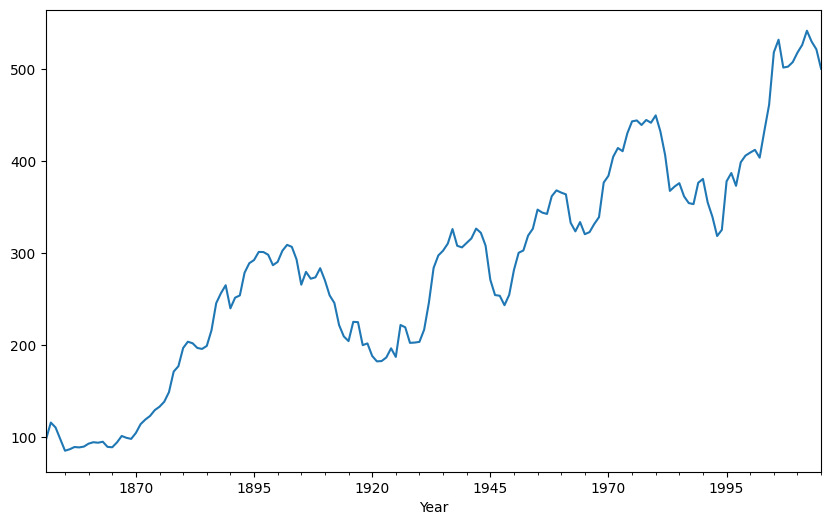

In [37]:
# Calculating the rolling mean
rolling_mean = hurricanes_per_year.rolling(window=12, min_periods=1).mean()
rolling_mean.plot(kind='line', figsize=(10, 6))

In [38]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [42]:
# Seasonality assessment
decomposition = seasonal_decompose(hurricanes_per_year, model='additive', period=12)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

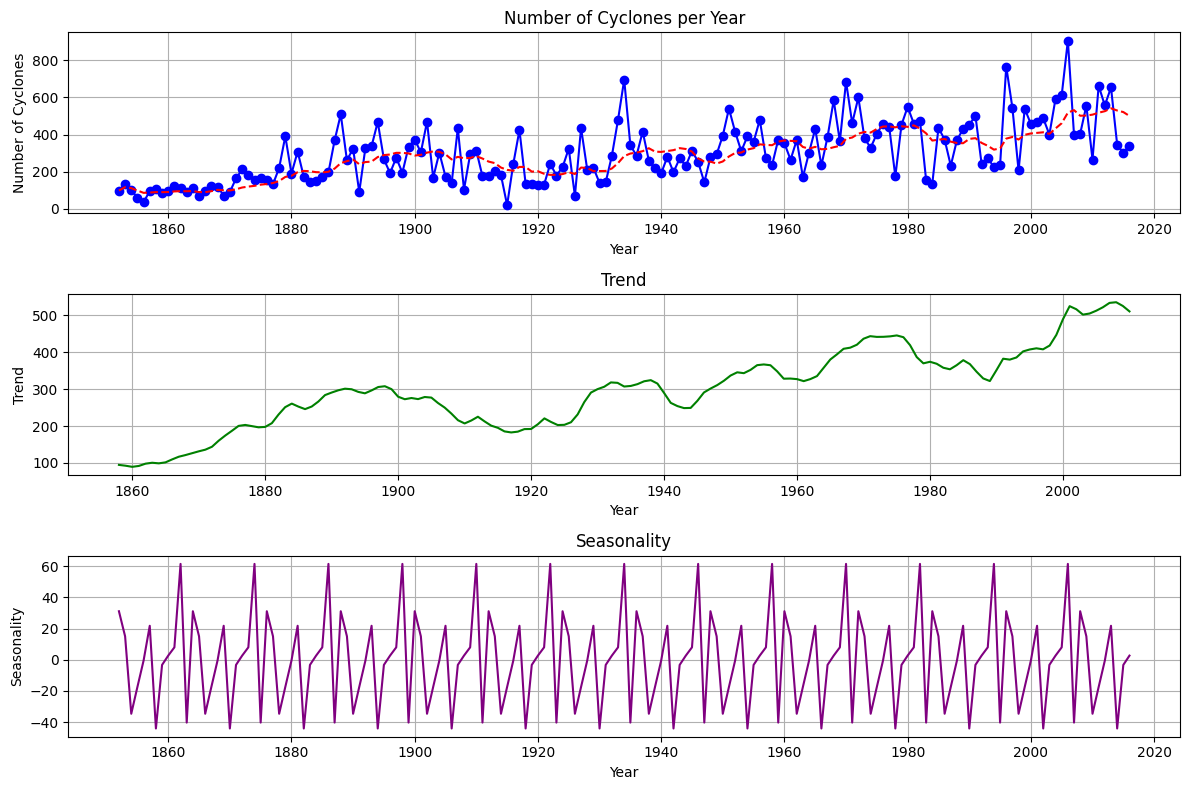

In [43]:
plt.figure(figsize=(12, 8))

# Plotting the time series and its rolling mean
plt.subplot(3, 1, 1)
plt.plot(hurricanes_per_year, marker='o', color='blue', linestyle='-')
plt.plot(rolling_mean, color='red', linestyle='--')
plt.title('Number of Cyclones per Year')
plt.xlabel('Year')
plt.ylabel('Number of Cyclones')
plt.grid(True)

# Plotting the trend component
plt.subplot(3, 1, 2)
plt.plot(trend, color='green')
plt.title('Trend')
plt.xlabel('Year')
plt.ylabel('Trend')
plt.grid(True)

# Plotting the seasonal component
plt.subplot(3, 1, 3)
plt.plot(seasonal, color='purple')
plt.title('Seasonality')
plt.xlabel('Year')
plt.ylabel('Seasonality')
plt.grid(True)

plt.tight_layout()
plt.show()

## Построим модель временного ряда

Разделим ряд на 2 выборки

In [44]:
original_data = hurricanes_per_year
train = original_data[:-23]
test = original_data[-23:]

### SARIMAX

В качестве экзогенных данных попробуем взять `Maximum Wind`, `Latitude_numeric`, `Longitude_numeric`

In [45]:
exog_data = df[['Maximum Wind', 'Latitude_numeric', 'Longitude_numeric']]

exog_data = exog_data.groupby(df['Year']).median()
exog_data.index = pd.to_datetime(exog_data.index, format='%Y').to_period('Y').to_timestamp('Y')

exog_data.head()

,Maximum Wind,Latitude_numeric,Longitude_numeric
Year,,,
1851-12-31,55.0,30.05,-74.60
1852-12-31,70.0,25.95,-76.05
1853-12-31,80.0,31.25,-58.05
1854-12-31,70.0,29.65,-80.40
1855-12-31,60.0,22.20,-67.90


Также разделим на 2 выборки

In [47]:
exog_data_train = exog_data[:-23]
exog_data_test = exog_data[-23:]

Инициализируем модель

Using auto_arima function from pmdarima library to automatically select the best SARIMAX model
- train: time series data for training the model
- exogenous: exogenous variables used in the model
- start_p, start_q: initial values for the AR and MA parameters
- test: type of unit root test to use in the stepwise search for the best model
- max_p, max_q: maximum values for the AR and MA parameters
- m: number of time steps in a seasonal period
- start_P: initial value for the seasonal AR parameter
- seasonal: whether or not to fit a seasonal ARIMA
- d, D: differencing orders for the non-seasonal and seasonal components
- trace: whether to print status on the fits
- error_action: what to do if an exception is encountered (ignore in this case)
- suppress_warnings: whether to suppress warnings given by ARIMA models
- stepwise: whether or not to use the stepwise algorithm when fitting

In [48]:
SARIMAX_model = pm.auto_arima(train, exogenous=exog_data_train,
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1,
                           trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True
                              )

SARIMAX_model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.54 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1707.711, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1671.823, Time=1.14 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.62 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1708.007, Time=0.09 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1694.747, Time=0.14 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1662.741, Time=2.86 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.06 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.70 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1670.326, Time=1.09 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1664.215, Time=2.12 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=1663.928, Time=1.65 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=1664.041, Time=1.47 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=1664.800, Time=5.23 sec
 ARIMA(1,0,0)(2,1,0)[12]             : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  142
Model:             SARIMAX(1, 0, 0)x(2, 1, 0, 12)   Log Likelihood                -826.370
Date:                            Wed, 07 Feb 2024   AIC                           1662.741
Time:                                    14:32:58   BIC                           1677.078
Sample:                                12-31-1851   HQIC                          1668.567
                                     - 12-31-1992                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     35.5683     13.013      2.733      0.006      10.063      61.073
ar.L1          0.2707      0.081      3.332      0.001       0.111       0.430
ar.S.L12      -0.5754      0.092     -6.229      0.000      -0.756      -0.394
ar.S.L24      -0.3045      0.087     -3.492      0.000      -0.475      -0.134
sigma2      1.873e+04   2382.135      7.863      0.000    1.41e+04    2.34e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 0.09
Prob(Q):                              0.87   Prob(JB):                         0.95
Heteroskedasticity (H):               1.92   Skew:                             0.06
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

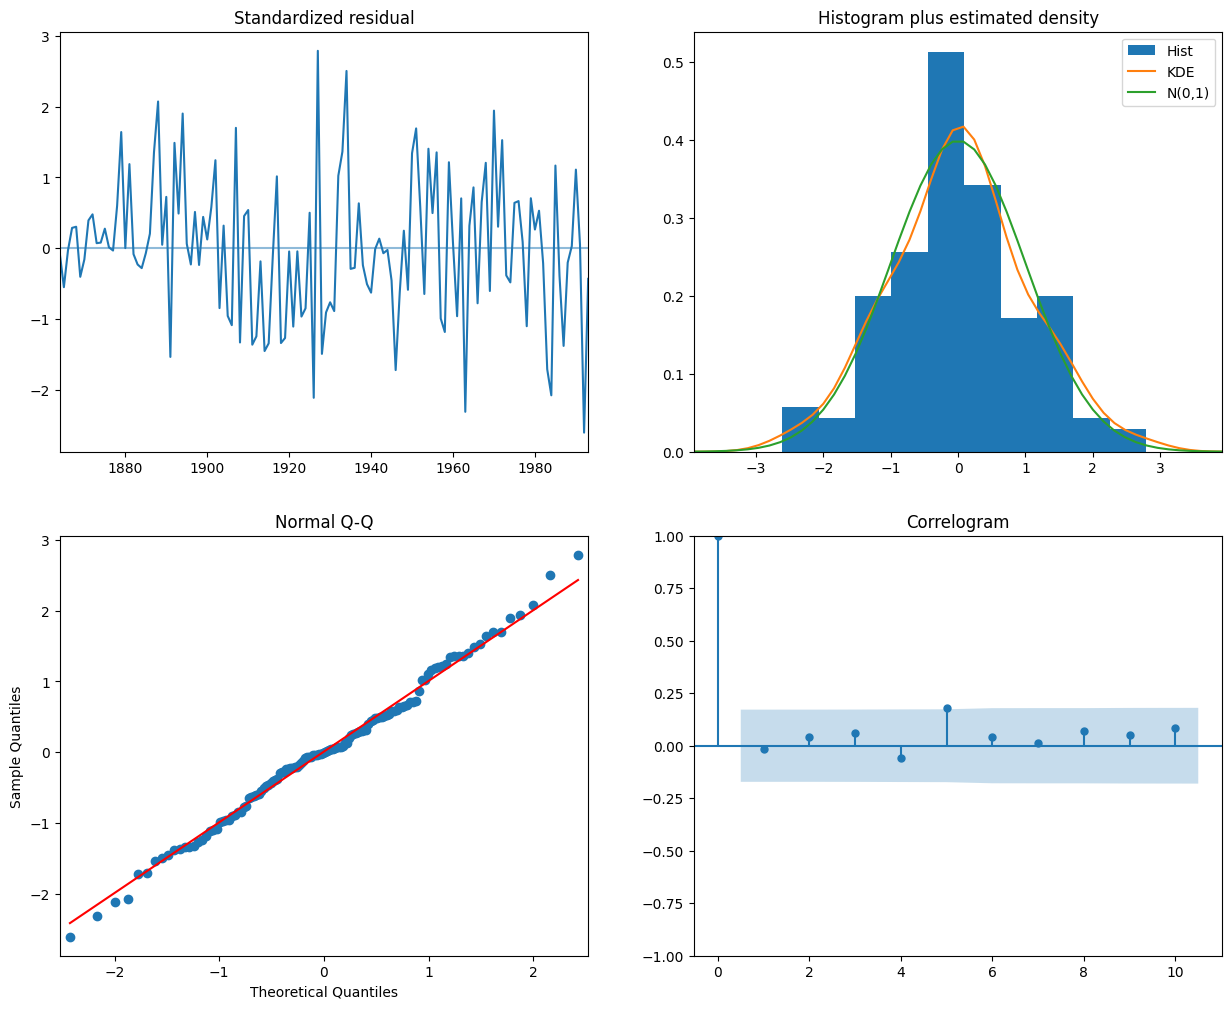

In [802]:
SARIMAX_model.plot_diagnostics(figsize=(15, 12))
plt.show()

Выполним предсказание этой модели и построим доверительные интервалы

In [49]:
fitted, confint = SARIMAX_model.predict(n_periods=len(test),
                                        exogenous=exog_data_test,
                                        return_conf_int=True)

In [52]:
# Generating the index for the forecast
index_of_fc = pd.date_range(test.index[0] + pd.DateOffset(years=1),
                            periods=len(test),
                            freq='Y')

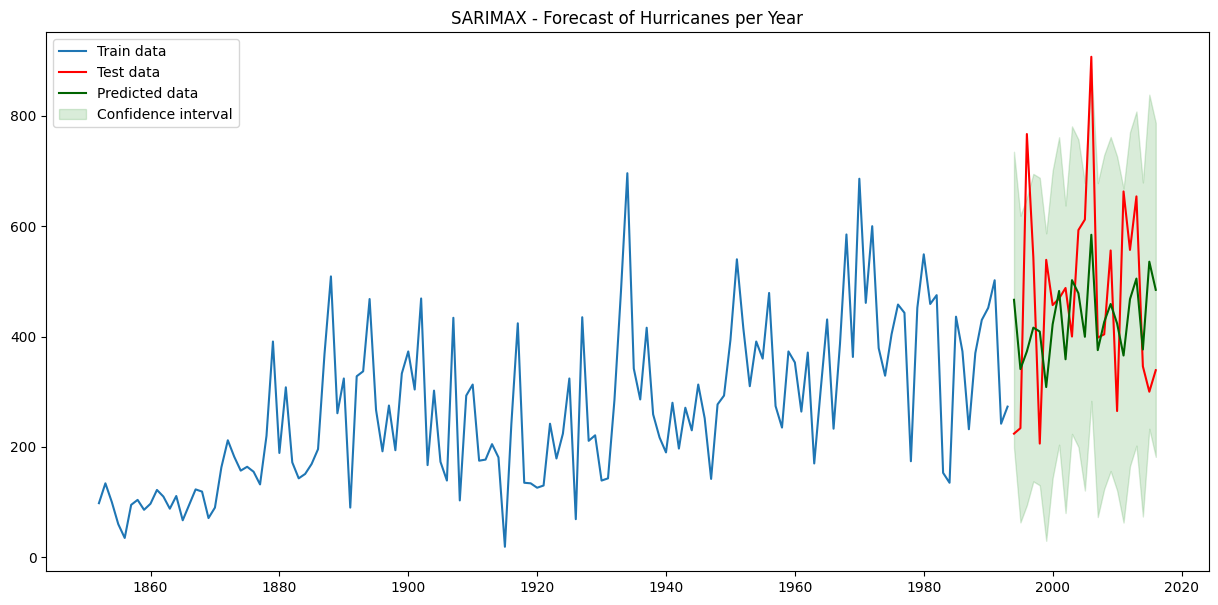

In [67]:
# Creating lower and upper confidence interval series
lower_series = pd.Series(confint[:, 0], index=fitted.index)
upper_series = pd.Series(confint[:, 1], index=fitted.index)

# Plot
plt.figure(figsize=(15,7))
plt.plot(train, color='#1f76b4', label="Train data")
plt.plot(test, color='red', label="Test data")
plt.plot(fitted, color='darkgreen', label="Predicted data")
plt.fill_between(lower_series.index,
                lower_series,
                upper_series,
                color='g', alpha=.15, label="Confidence interval")
plt.xlabel("Year")
plt.ylabel("Count")
plt.legend()
plt.title("SARIMAX - Forecast of Hurricanes per Year")
plt.show()

In [54]:
# Calculating the Mean Squared Error (MSE) between the predicted values (fitted) and the actual test values
mse = mean_squared_error(fitted, test)
print(f"SARIMAX Test RMSE: {np.sqrt(mse)}")

SARIMAX Test RMSE: 181.6484902818162


### Попробуем построить другую модель SARIMA

Выполним аналогичные действия

In [55]:
SARIMA_model = pm.auto_arima(train,
                             start_p=1, start_q=1,
                             test='adf',
                             max_p=3, max_q=3,
                             m=12, #12 is the frequency of the cycle
                             start_P=0,
                             seasonal=True, #set to seasonal
                             d=None,
                             D=1, #order of the seasonal differencing
                             trace=True,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=True)

print(SARIMA_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.63 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1707.711, Time=0.07 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1671.823, Time=1.12 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.51 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1708.007, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1694.747, Time=0.11 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1662.741, Time=1.54 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.06 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.71 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1670.326, Time=1.07 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1664.215, Time=2.10 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=1663.928, Time=1.63 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=1664.041, Time=2.81 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=1664.800, Time=6.88 sec
 ARIMA(1,0,0)(2,1,0)[12]             : 

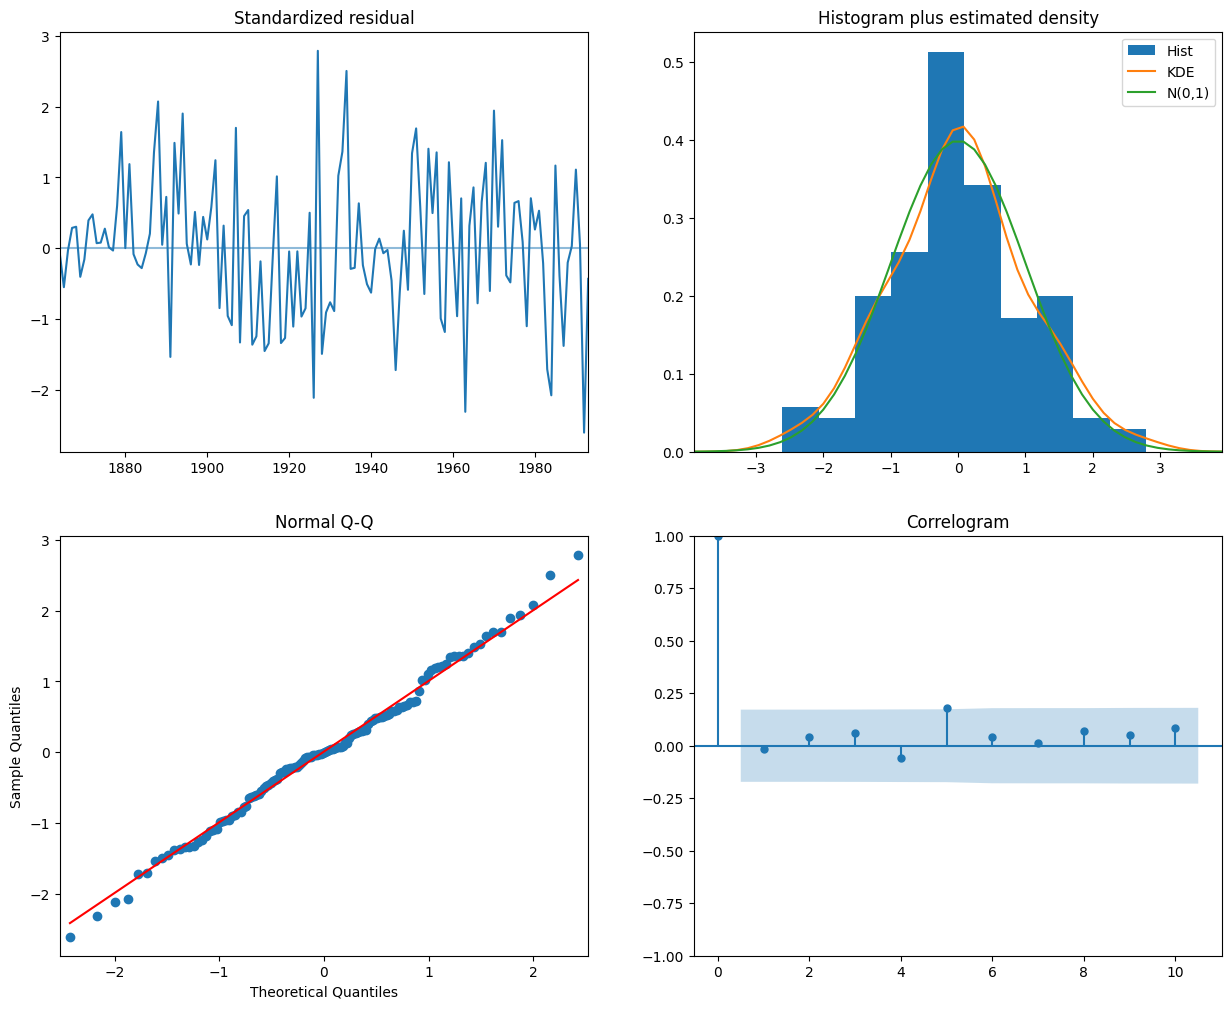

In [56]:
SARIMA_model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [60]:
fitted, confint = SARIMA_model.predict(n_periods=len(test),
                                       return_conf_int=True)

In [61]:
# Generating the index for the forecast
index_of_fc = pd.date_range(test.index[0] + pd.DateOffset(years=1),
                            periods=len(test),
                            freq='Y')

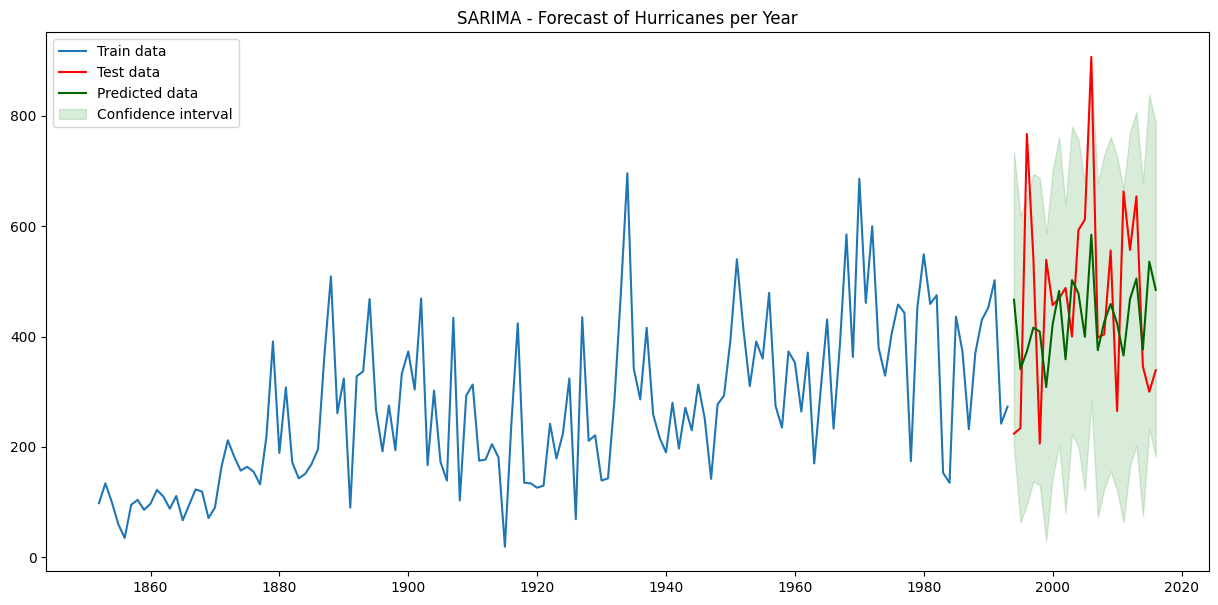

In [66]:
# Creating lower and upper confidence interval series
lower_series = pd.Series(confint[:, 0], index=fitted.index)
upper_series = pd.Series(confint[:, 1], index=fitted.index)

# Plot
plt.figure(figsize=(15,7))
plt.plot(train, color='#1f76b4', label="Train data")
plt.plot(test, color='red', label="Test data")
plt.plot(fitted, color='darkgreen', label="Predicted data")
plt.fill_between(lower_series.index,
                lower_series,
                upper_series,
                color='g', alpha=.15, label="Confidence interval")
plt.xlabel("Year")
plt.ylabel("Count")
plt.legend()
plt.title("SARIMA - Forecast of Hurricanes per Year")
plt.show()

In [63]:
# Calculating the Mean Squared Error (MSE) between the predicted values (fitted) and the actual test values
mse = mean_squared_error(fitted, test)
print(f"SARIMA Test RMSE: {np.sqrt(mse)}")

SARIMA Test RMSE: 181.6484902818162


Никаких отличий не наблюдается, по сравнению с моделью SARIMAX

Выполним прогноз на несколько лет

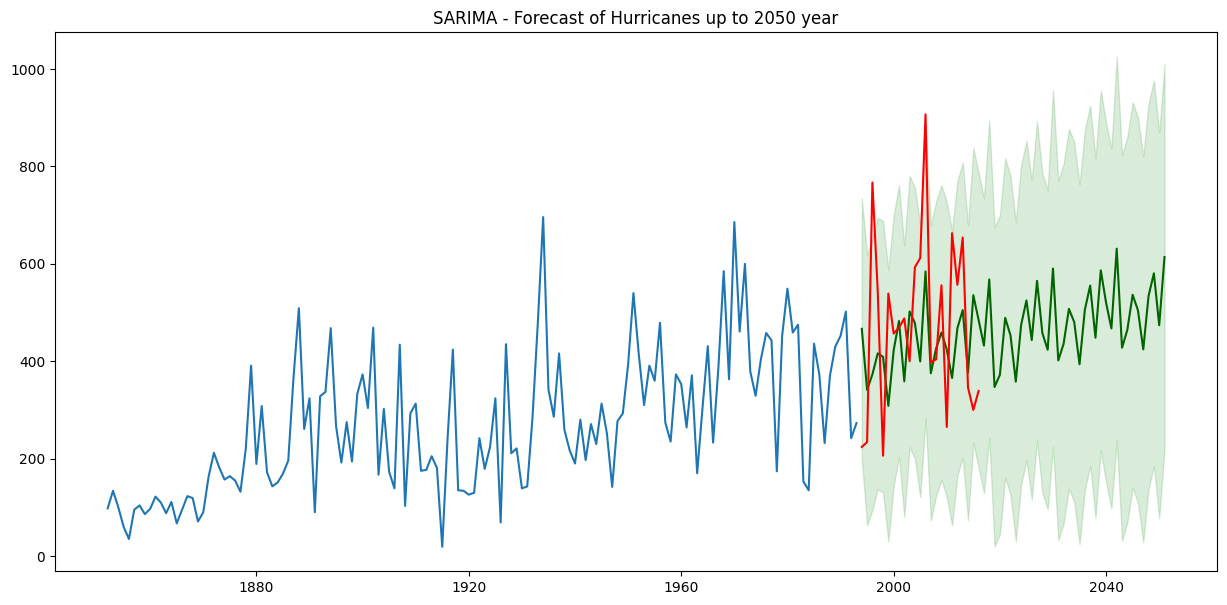

In [70]:
# Setting the target year for forecasting
year = 2050

# Calculating the number of periods needed for forecasting based on the target year
n_periods = year - max(train.index.year)

# Making predictions with the SARIMA model
fitted, confint = SARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(train.index[-1] + pd.DateOffset(years=1),
                            periods=n_periods, freq='Y')

# Creating series for the predicted values, lower and upper confidence intervals
fitted_series = pd.Series(fitted.values, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plotting
plt.figure(figsize=(15,7))
plt.plot(train, color='#1f76b4', label="Train data")
plt.plot(fitted_series, color='darkgreen', label="Predicted data")
plt.plot(test, color='red', label="Test data")
plt.fill_between(lower_series.index,
                lower_series,
                upper_series,
                color='g', alpha=.15, label="Confidence interval")

plt.xlabel("Year")
plt.ylabel("Count")
plt.legend()
plt.title(f"SARIMA - Forecast of Hurricanes up to {year} year")
plt.show()

### Построим нейросетевую модель (RNN)

In [132]:
dataset = df.groupby('Year')['Status'].size()
dataset.head()

Year
1851     98
1852    134
1853    100
1854     60
1855     35
Name: Status, dtype: int64

In [133]:
dataset = dataset.astype('float32')
dataset.shape

(165,)

Выполним нормализацию данных

In [134]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset.values.reshape(-1, 1))

Разделим данные на 2 выборки

In [135]:
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[0:train_size, :], scaled_data[train_size:, :]
test_data_index = dataset[train_size:].index

In [136]:
train_data.shape, test_data.shape

((132, 1), (33, 1))

In [137]:
def get_data(data: np.ndarray, look_back: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Generate input sequences and output values for a time series dataset.

    Args:
    - data (np.ndarray): The time series dataset.
    - look_back (int): The number of previous time steps to use as input features.

    Returns:
    - Tuple[np.ndarray, np.ndarray]: A tuple containing input sequences and corresponding output values.
    """
    dataX, dataY = [], []
    for i in range(len(data) - look_back - 1):
        dataX.append(data[i:(i + look_back), 0])
        dataY.append(data[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [138]:
# Define the look-back window size
look_back = 5

# Get input sequences and output values for the training and testing sets
X_train, y_train = get_data(train_data, look_back)
X_test, y_test = get_data(test_data, look_back)

In [139]:
# Reshape the input sequences for compatibility with the input shape expected by the RNN model
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

Определим архитектуру нейросетевой модели

In [140]:
model = Sequential()
model.add(LSTM(32, input_shape=(1, look_back)))
model.add(Dense(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [141]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 32)                4864      
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5953 (23.25 KB)
Trainable params: 5953 (23.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [142]:
wandb.init(project='task_3_RNN')

Выполним обучение

In [143]:
history = model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1, callbacks=[WandbCallback()])

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/100
  1/126 [..............................] - ETA: 6:21 - loss: 0.1941

126/126 [==============================] - 3s 3ms/step - loss: 0.0210
Epoch 2/100
126/126 [==============================] - 0s 2ms/step - loss: 0.0185
Epoch 3/100
126/126 [==============================] - 0s 2ms/step - loss: 0.0181
Epoch 4/100
126/126 [==============================] - 0s 2ms/step - loss: 0.0172
Epoch 5/100
126/126 [==============================] - 0s 2ms/step - loss: 0.0171
Epoch 6/100
126/126 [==============================] - 0s 2ms/step - loss: 0.0166
Epoch 7/100
126/126 [==============================] - 0s 2ms/step - loss: 0.0176
Epoch 8/100
126/126 [==============================] - 0s 2ms/step - loss: 0.0171
Epoch 9/100
126/126 [==============================] - 0s 2ms/step - loss: 0.0173
Epoch 10/100
126/126 [==============================] - 0s 3ms/step - loss: 0.0168
Epoch 11/100
126/126 [==============================] - 0s 3ms/step - loss: 0.0166
Epoch 12/100
126/126 [==============================] - 0s 3ms/step - loss: 0.0174
Epoch 13/100
126/126 [===

Выполним предсказание

In [85]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

1/1 [==============================] - 0s 33ms/step


In [86]:
# Making predictions on the training and test data
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

In [88]:
# Calculating the RMSE for the test dataset
test_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:, 0]))
print("LSTM Test RMSE: ", test_rmse)

LSTM Test RMSE:  203.02839692357458


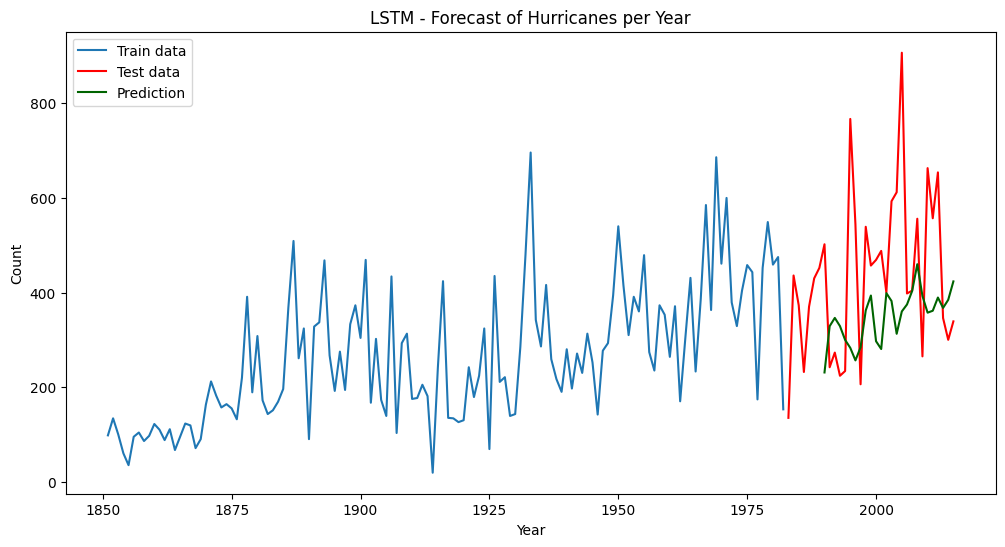

In [144]:
fig = plt.figure(figsize=(12, 6))
plt.plot(dataset[:-len(test_data_index)], label="Train data")
plt.plot(dataset[-len(test_data_index):], label="Test data", color="red")
plt.plot(test_data_index[7:], test_predict[:-1], label="Prediction", color="darkgreen")
plt.xlabel("Year")
plt.ylabel("Count")
plt.title(f"LSTM - Forecast of Hurricanes per Year")
plt.legend()
plt.show()

In [145]:
wandb.log({"LSTM - Forecast of Hurricanes per Year": wandb.Image(fig)})

Выполним предсказание на несколько лет

In [146]:
year = 2050
period = year - max(dataset.index)

future_predictions = []

# Initial data for forecasting
input_data = scaled_data[-look_back:].reshape(1, 1, look_back)

# Forecasting several years ahead
for i in range(1, period + 1):
    future_prediction = model.predict(input_data)
    future_predictions.append(future_prediction[0, 0])

    # Update input data for the next forecast
    input_data = np.append(input_data[:, :, 1:], future_prediction).reshape(1, 1, look_back)


# Invert scaling to obtain actual values
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

1/1 [==============================] - 0s 33ms/step


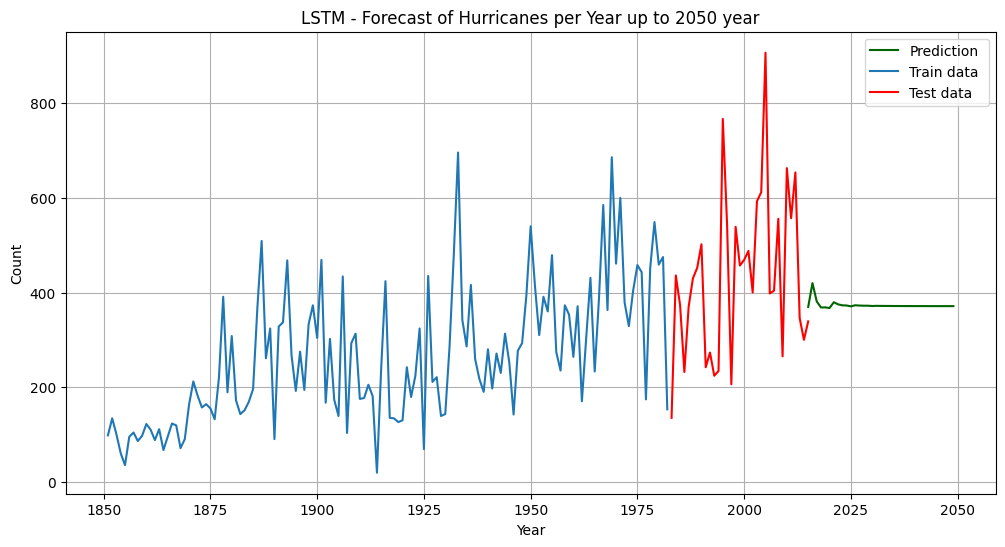

In [148]:
# Создание массива индексов для будущих лет
future_years = range(2015, year)

# Создание массива индексов для исходных лет
original_years = range(1990, 2016)

# Построение графика
fig = plt.figure(figsize=(12, 6))

plt.plot(future_years, future_predictions, label="Prediction", color="darkgreen")
plt.plot(dataset[:-len(test_data_index)], label="Train data ")
plt.plot(dataset[-len(test_data_index):], label="Test data", color="red")

plt.xlabel("Year")
plt.ylabel("Count")
plt.title(f"LSTM - Forecast of Hurricanes per Year up to {year} year")
plt.legend()
plt.grid(True)
plt.show()

In [149]:
wandb.log({"LSTM - Forecast of Hurricanes per Year up to {year} year": wandb.Image(fig)})

In [150]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▂▃▂▃▂▃▃▃▃▃▃▂▁▂▃▂▂▃▂▂▂▂▃▂▃▂▂▂▂▂▂▂▃▁▂▁▂▂
epoch,99
loss,0.01606


Как видно, то результат не очень утешительный, по сравнению с моделями ARIMA. На мой взгляд такое обучение не подходит для таких данных. Но я не исключаю того, что я сделал что-то неверно.

На ближайшие 5-10 лет результаты вполне удовлетворительные, но выполняя прогноз на более далекое будущее не все так однозначно.

В связи с этим будем работать с моделью SARIMA

## Итоговая модель

### SARIMA

In [118]:
wandb.init(project="task_3")

wandb: Currently logged in as: pan_ae (pnntly). Use `wandb login --relogin` to force relogin


In [119]:
SARIMA_model = pm.auto_arima(hurricanes_per_year,
                             start_p=1, start_q=1,
                             test='adf',
                             max_p=3, max_q=3,
                             m=12, #12 is the frequency of the cycle
                             start_P=0,
                             seasonal=True, #set to seasonal
                             d=None,
                             D=1, #order of the seasonal differencing
                             trace=True,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=True)

print(SARIMA_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.82 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2037.421, Time=0.07 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1984.139, Time=1.10 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.87 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2039.836, Time=0.04 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2023.498, Time=0.17 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1971.148, Time=3.99 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=6.90 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.42 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1977.647, Time=2.25 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1972.873, Time=2.25 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=1972.832, Time=4.88 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=1971.957, Time=1.91 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=1973.658, Time=3.90 sec
 ARIMA(1,0,0)(2,1,0)[12]             : 

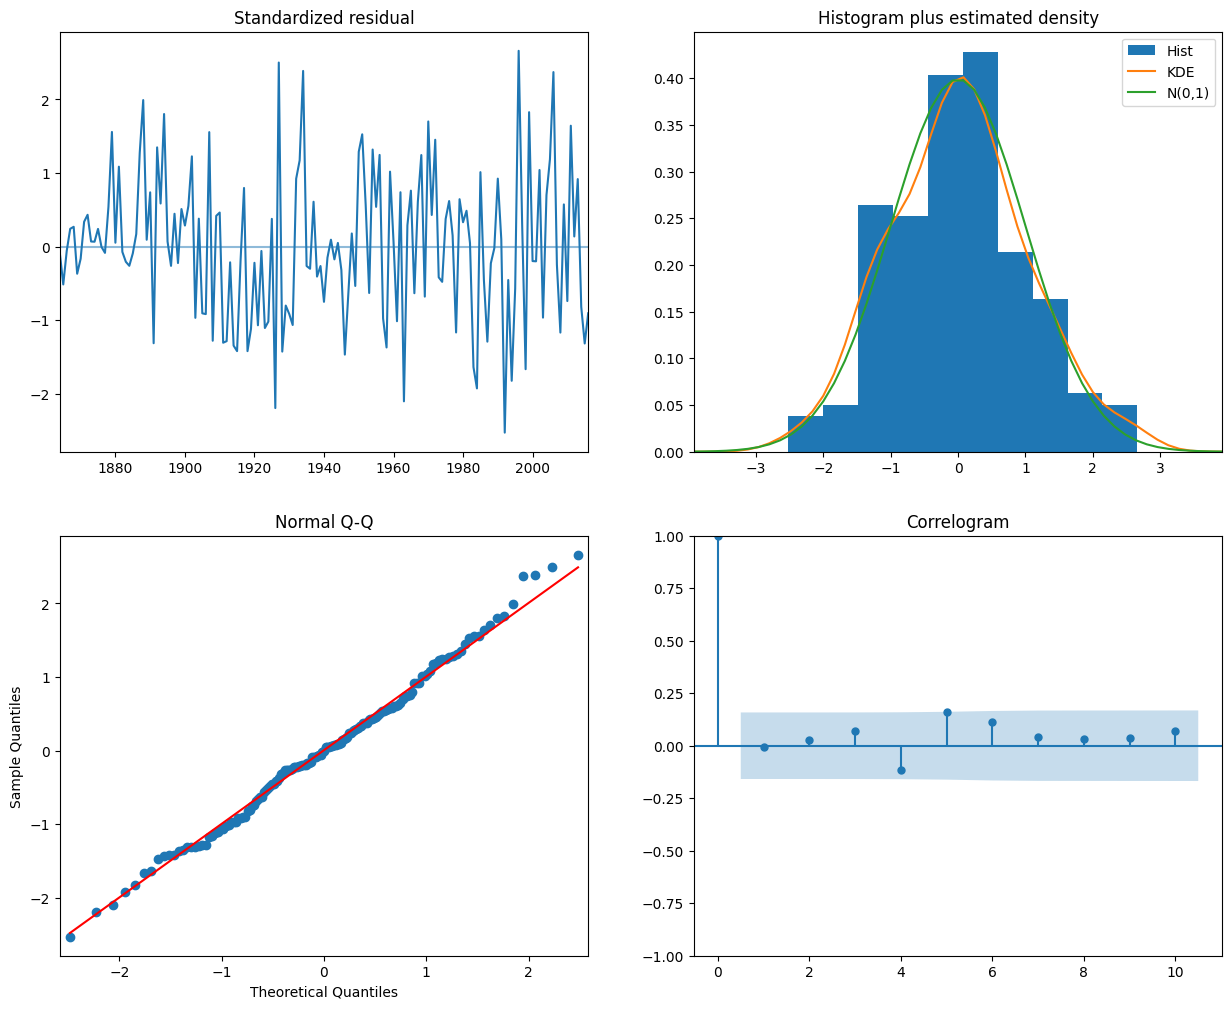

In [120]:
SARIMA_model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [122]:
fitted, confint = SARIMA_model.predict(n_periods=len(hurricanes_per_year),
                                       return_conf_int=True)

In [123]:
index_of_fc = pd.date_range(hurricanes_per_year.index[-1] + pd.DateOffset(years=1),
                            periods=len(hurricanes_per_year),
                            freq='Y')

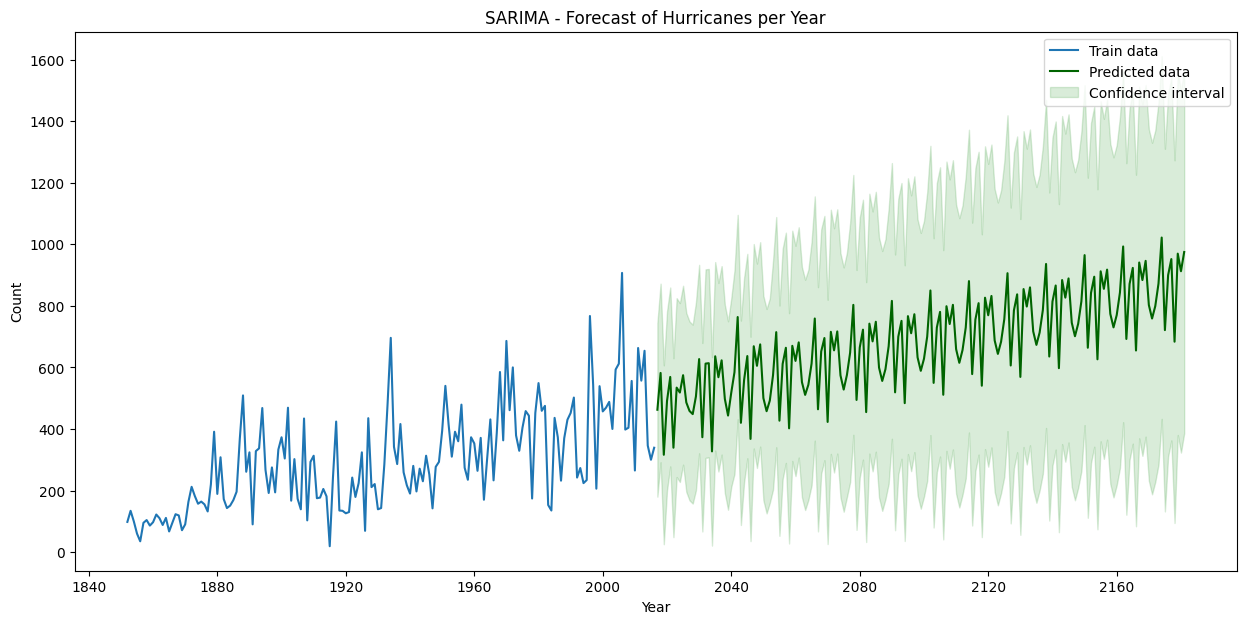

In [126]:
# Creating lower and upper confidence interval series
lower_series = pd.Series(confint[:, 0], index=fitted.index)
upper_series = pd.Series(confint[:, 1], index=fitted.index)

# Plot
fig = plt.figure(figsize=(15, 7))
plt.plot(hurricanes_per_year, color='#1f76b4', label="Train data")
plt.plot(fitted, color='darkgreen', label="Predicted data")
plt.fill_between(lower_series.index,
                lower_series,
                upper_series,
                color='g', alpha=.15, label="Confidence interval")
plt.xlabel("Year")
plt.ylabel("Count")
plt.legend()
plt.title("SARIMA - Forecast of Hurricanes per Year")
plt.show()

In [129]:
wandb.log({"SARIMA - Forecast of Hurricanes per Year": wandb.Image(fig)})

In [130]:
wandb.finish()

Сохраним модель

In [102]:
import joblib

In [103]:
joblib.dump(SARIMAX_model, "/content/SARIMA_model.pkl")

['/content/SARIMA_model.pkl']

Вызов модели

In [104]:
SARIMAX_model = joblib.load("/content/SARIMA_model.pkl")

Выполним прогноз на 2020 год

In [109]:
def get_forecast(model, data, year=2016):
    n_periods = year - max(data.index.year)

    fitted, confint = model.predict(n_periods=n_periods,
                                    return_conf_int=True)
    index_of_fc = pd.date_range(data.index[-1] + pd.DateOffset(years=1),
                                periods=n_periods, freq='Y')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted.values, index=index_of_fc)

    return fitted_series[fitted_series.index.year == year]

In [110]:
result = get_forecast(SARIMAX_model, hurricanes_per_year, 2020)
result

2020-12-31    409.022555
Freq: A-DEC, dtype: float64